# interpolación de temperaturas

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import geopandas as gpd
from shapely.geometry import Point
import contextily as cx

# --- 1. Cargar los datos ---
# Lee el archivo CSV que proporcionaste.
df = pd.read_csv("./SMN_data/df_ok.csv")


Rango de temperatura interpolada: Mín = -1.66, Máx = 21.45
El mapa final se ha guardado como 'heatmap_con_contextily_final.png'


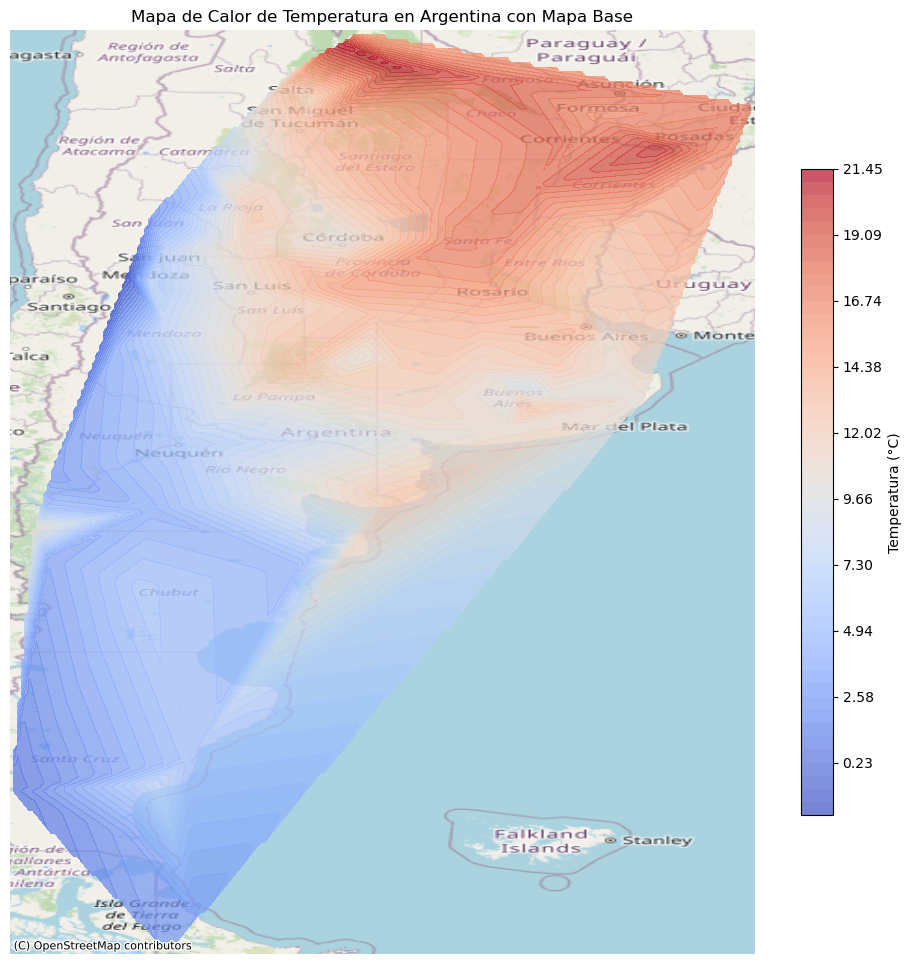

In [3]:
# --- 2. Limpiar y filtrar los datos ---
df_clean = df.dropna(subset=['TEMP (°C)', 'LAT', 'LON'])
df_continental = df_clean[df_clean['LAT'] > -60].copy()

# --- 3. Crear un GeoDataFrame ---
geometry = [Point(xy) for xy in zip(df_continental['LON'], df_continental['LAT'])]
gdf = gpd.GeoDataFrame(df_continental, geometry=geometry, crs="EPSG:4326")

# --- 4. Reproyectar a Web Mercator ---
gdf_wm = gdf.to_crs(epsg=3857)

# Extrae las coordenadas reproyectadas y los valores de temperatura.
x_wm = gdf_wm.geometry.x
y_wm = gdf_wm.geometry.y
temps = gdf_wm['TEMP (°C)'].values

# --- 5. Crear la grilla de interpolación ---
grid_x_wm, grid_y_wm = np.mgrid[
    x_wm.min():x_wm.max():200j,
    y_wm.min():y_wm.max():200j
]

# Interpola los valores de temperatura.
points = np.vstack((x_wm, y_wm)).T
grid_temps = griddata(points, temps, (grid_x_wm, grid_y_wm), method='linear')

# --- 6. Verificación de Datos (Debugging) ---
# Comprueba el rango de temperaturas interpoladas, ignorando valores nulos.
temp_min = np.nanmin(grid_temps)
temp_max = np.nanmax(grid_temps)
print(f"Rango de temperatura interpolada: Mín = {temp_min:.2f}, Máx = {temp_max:.2f}")

# --- 7. Generar el mapa ---
fig, ax = plt.subplots(figsize=(12, 12))

# Define los niveles para el gráfico de contorno.
levels = np.linspace(temp_min, temp_max, 50)

# Dibuja el mapa de calor, asegurando que esté en una capa superior (zorder=1).
contour = ax.contourf(grid_x_wm, grid_y_wm, grid_temps, levels=levels, cmap='coolwarm', alpha=0.7, zorder=1)

# Añade el mapa base (se dibujará en la capa inferior, zorder=0).
cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik)

# --- 8. Configurar los detalles del gráfico ---
cbar = fig.colorbar(contour, ax=ax, shrink=0.7)
cbar.set_label('Temperatura (°C)')
ax.set_title('Mapa de Calor de Temperatura en Argentina con Mapa Base')
ax.set_axis_off()

# Guarda la figura.
plt.savefig('heatmap_con_contextily_final.png', dpi=300, bbox_inches='tight', pad_inches=0.1)

print("El mapa final se ha guardado como 'heatmap_con_contextily_final.png'")



In [ ]:
import pandas as pd
import geopandas as gpd
import folium
import requests
import branca.colormap as cm

# --- 1. Cargar y transformar los datos de temperatura ---
#df = pd.read_csv('df_ok.csv')
#df.dropna(subset=['TEMP (°C)'], inplace=True)

# Convertir las columnas one-hot a una única columna 'Provincia_raw'
prov_cols = [col for col in df.columns if col.startswith('PROV_')]
df['Provincia_raw'] = df[prov_cols].idxmax(axis=1).str.replace('PROV_', '')

# --- 2. Mapeo de nombres para corregir inconsistencias y acentos ---
prov_map = {
    'BUENOS AIRES': 'Buenos Aires', 'CAPITAL FEDERAL': 'Ciudad Autónoma de Buenos Aires',
    'CATAMARCA': 'Catamarca', 'CHACO': 'Chaco', 'CHUBUT': 'Chubut', 'CORDOBA': 'Córdoba',
    'CORRIENTES': 'Corrientes', 'ENTRE RIOS': 'Entre Ríos', 'FORMOSA': 'Formosa',
    'JUJUY': 'Jujuy', 'LA PAMPA': 'La Pampa', 'LA RIOJA': 'La Rioja',
    'MENDOZA': 'Mendoza', 'MISIONES': 'Misiones', 'NEUQUEN': 'Neuquén',
    'RIO NEGRO': 'Río Negro', 'SALTA': 'Salta', 'SAN JUAN': 'San Juan',
    'SAN LUIS': 'San Luis', 'SANTA CRUZ': 'Santa Cruz', 'SANTA FE': 'Santa Fe',
    'SANTIAGO DEL ES': 'Santiago del Estero',
    'TIERRA DEL FUEG': 'Tierra del Fuego, Antártida e Islas del Atlántico Sur',
    'TUCUMAN': 'Tucumán'
}
df['Provincia'] = df['Provincia_raw'].map(prov_map)

# Calcular la temperatura promedio por provincia
temp_promedio_prov = df.groupby('Provincia')['TEMP (°C)'].mean().reset_index()
temp_promedio_prov.rename(columns={'TEMP (°C)': 'Temperatura_Promedio'}, inplace=True)

# --- 3. Obtener los datos geoespaciales desde la API oficial ---
# URL de la API de datos.gob.ar solicitando la geometría completa (polígonos)
geojson_url = 'https://apis.datos.gob.ar/georef/api/provincias?formato=geojson&campos=id,nombre,geometria'
try:
    gdf_provincias = gpd.read_file(geojson_url)
    print("GeoJSON de contornos de provincias cargado correctamente desde la API oficial.")
except Exception as e:
    print(f"Error al cargar el GeoJSON desde la API: {e}")
    exit()

# --- 4. Unir los datos de temperatura con el GeoDataFrame ---
merged_gdf = gdf_provincias.merge(temp_promedio_prov, left_on='nombre', right_on='Provincia', how='left')
print(f"Se unieron datos para {merged_gdf['Temperatura_Promedio'].notna().sum()} de {len(merged_gdf)} provincias.")

# --- 5. Crear el mapa coroplético con el método GeoJson (más robusto) ---
m = folium.Map(location=[-40, -64], zoom_start=4, tiles='CartoDB positron')

# Crear una escala de colores lineal
min_temp = merged_gdf['Temperatura_Promedio'].min()
max_temp = merged_gdf['Temperatura_Promedio'].max()
colormap = cm.linear.YlOrRd_09.scale(min_temp, max_temp)
colormap.caption = 'Temperatura Promedio (°C)'
m.add_child(colormap)

# Función para asignar un color a cada provincia
def style_function(feature):
    provincia_nombre = feature['properties']['nombre']
    temp_series = merged_gdf.loc[merged_gdf['nombre'] == provincia_nombre, 'Temperatura_Promedio']
    
    if not temp_series.empty and pd.notna(temp_series.iloc[0]):
        temp = temp_series.iloc[0]
        return {
            'fillOpacity': 0.7,
            'weight': 1,
            'color': 'black',
            'fillColor': colormap(temp)
        }
    else:
        return {
            'fillOpacity': 0.3,
            'weight': 1,
            'color': 'black',
            'fillColor': '#d3d3d3' # Gris para provincias sin datos
        }

# Crear y añadir la capa GeoJson
folium.GeoJson(
    merged_gdf,
    style_function=style_function,
    tooltip=folium.GeoJsonTooltip(
        fields=['nombre', 'Temperatura_Promedio'],
        aliases=['Provincia:', 'Temp. Promedio (°C):'],
        localize=True,
        sticky=False,
        style="""
            background-color: #F0EFEF;
            border: 2px solid black;
            border-radius: 3px;
            box-shadow: 3px;
        """
    )
).add_to(m)

# --- 6. Visualizar el mapa en el notebook ---
# Esta debe ser la última línea de la celda para que el mapa se muestre.
m


Error al cargar el GeoJSON desde la API: HTTP Error 400: Bad Request


NameError: name 'gdf_provincias' is not defined

: 

el problema es que en el geojson los datos son puntos no poligonos